## <span style="color:DarkGreen"> *Meteogram for NYSM Observations & The High Resolution Ensemble Forecast (HREF)* </span>
***
<div class="alert alert-block alert-success">
<b>Notes:</b> HRRR Model is the only model that displays "inbetween precipitation" !
</div>

#### **Observations Used:**
###### *- New York State Mesonet (NYSM)*

#### **Valid NYSM Stations:**
###### *-ESSX, WFMB, GABR, LOUI, EDWA, PHIL, POTS, TUPP, CAPE, MALO, CHAZ, NHUD, HAMM, SARA, WELL*

#### **HREF Members Used:**

###### *- Advanced Research Weather (HRW WRF-ARW)*
###### *- Finite Volume Cubed Sphere (HRW WRF-FV3)*
###### *- National Severe Storms Laboratory (HRW WRF-NSSL)*
###### *- North American Model (NAM 3km CONUS)*
###### *- High Resolution Rapid Refresh (HRRR)*

### Inputs

In [1]:
# NYSM Station(s) Select
nysmstation = ['ELLE']

# Meteogram Start Time
start_year = '2022' 
start_month = '02' 
start_day= '17' 
start_hour = '23' 

# Meteogram End Time
end_year = '2022' 
end_month = '02' 
end_day= '18' 
end_hour = '9' #8

# HREF Initialization Time 
year = '2022' 
month = '02' 
day= '17' 
hour = '12' 

# HREF Forecast Time
starthour = 11 # 11 
endhour = 21 # 20

### Imports

In [2]:
%matplotlib inline

# core
import os
import sys
import glob
import math
import cfgrib
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import matplotlib as mpl

# netCDF4
import netCDF4 as nc
from netCDF4 import Dataset

# datetime
from datetime import datetime,timedelta

#cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeat

# matplotlib
import matplotlib.colors as mcolors
import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.dates import DateFormatter, AutoDateLocator,HourLocator,DayLocator,MonthLocator

# metpy
import metpy.calc as mpcalc
from metpy.units import units
from metpy.plots import StationPlot
from metpy.calc import wind_speed, wind_direction, relative_humidity_from_dewpoint, wind_components
from metpy.calc import wind_speed, wind_direction, relative_humidity_from_dewpoint, wind_components

### File Building

In [3]:
### Grabbing files from the NYSM and NSSL
starttime = start_year + '-' +start_month + '-' + start_day + ' ' + start_hour + ':00'
endtime = end_year + '-' +end_month + '-' + end_day + ' ' + end_hour + ':00'
reset_time = '2022-02-18 0:00'###########################
return_time = '2022-02-18 0:05'###########################
##################################################################################

timerange = pd.date_range(start=starttime,end=endtime,freq='5min')

base_dir = '/network/rit/lab/minderlab_rit/NYSM'
standard_dir = '/standard/netCDF/2022'
winter_dir = '/winter_products'
winter_1 = base_dir + winter_dir + '/' + start_year + start_month + start_day + '.nc'
winter_2 = base_dir + winter_dir + '/' + end_year + end_month + end_day + '.nc'
standard_1 = base_dir + standard_dir + '/' + start_year + start_month + start_day + '.nc'
standard_2 = base_dir + standard_dir + '/' + end_year + end_month + end_day + '.nc'
print('We are using the following paths to grab NYSM data:')
print(winter_1)
print(winter_2)
print(standard_1)
print(standard_2)
print()
#sdata = xr.open_mfdataset([standard_1]) 
#wdata = xr.open_mfdataset([winter_1])
sdata = xr.open_mfdataset([standard_1,standard_2])
wdata = xr.open_mfdataset([winter_1,winter_2])

####################################################################################

timerange_HREF = pd.date_range(start=starttime,end=endtime,freq='1H')
timerange_HREF_NAM = pd.date_range(start=starttime,end=endtime,freq='3H')

endhour = endhour +1
href_base_dir = '/network/rit/lab/minderlab_rit/je845911/data/href'
yyyymmddhh_str = year + month + day + hour
yyyymmdd_str = yyyymmddhh_str[0:8]
yyyy_str = yyyymmddhh_str[0:4]
fhrs = np.arange(starthour,endhour,1)
endhour2 = int(start_hour)-(int(hour)+1) # Begining of meteogram
starthour2 = int(hour)-int(hour)# Initialization Hour 
fhrs_adj = np.arange(starthour2,endhour2+1,1) # Time range from int hour to begining of meteogram

arw, fv3, nssl, ncep, nam = [],[],[],[],[]
for fhr in fhrs:
    arw.append(f'{href_base_dir}/{yyyy_str}/{yyyymmdd_str}/hiresw_conusarw_' + f'{yyyymmddhh_str}f0'+str(fhr).zfill(2)+'.grib2')
    fv3.append(f'{href_base_dir}/{yyyy_str}/{yyyymmdd_str}/hiresw_conusfv3_' + f'{yyyymmddhh_str}f0'+str(fhr).zfill(2)+'.grib2')
    nssl.append(f'{href_base_dir}/{yyyy_str}/{yyyymmdd_str}/hiresw_conusnssl_' + f'{yyyymmddhh_str}f0'+str(fhr).zfill(2)+'.grib2')
    ncep.append(f'{href_base_dir}/{yyyy_str}/{yyyymmdd_str}/hrrr_ncep_' + f'{yyyymmddhh_str}f0'+str(fhr).zfill(2)+'.grib2')
    nam.append(f'{href_base_dir}/{yyyy_str}/{yyyymmdd_str}/nam_conusnest_' + f'{yyyymmddhh_str}f0'+str(fhr).zfill(2)+'.grib2')

fv3adj, namadj = [],[]
for fhr in fhrs_adj:
    fv3adj.append(f'{href_base_dir}/{yyyy_str}/{yyyymmdd_str}/hiresw_conusfv3_' + f'{yyyymmddhh_str}f0'+str(fhr).zfill(2)+'.grib2')
    namadj.append(f'{href_base_dir}/{yyyy_str}/{yyyymmdd_str}/nam_conusnest_' + f'{yyyymmddhh_str}f0'+str(fhr).zfill(2)+'.grib2')

print("We are using the following paths to grab HREF (ARW) data:")
for fpath in arw:
    print(fpath)
print()
print("We are using the following paths to grab HREF (FV3) data:")
for fpath in fv3adj:
    print(fpath)
for fpath in fv3:
    print(fpath)
print()
print("We are using the following paths to grab HREF (NCEP) data:")
for fpath in nssl:
    print(fpath)
print()
print("We are using the following paths to grab HREF (NSSL) data:")
for fpath in ncep:
    print(fpath)
print()
print("We are using the following paths to grab HREF (NAM) data:")
for fpath in namadj:
    print(fpath)
for fpath in nam:
    print(fpath)


We are using the following paths to grab NYSM data:
/network/rit/lab/minderlab_rit/NYSM/winter_products/20220217.nc
/network/rit/lab/minderlab_rit/NYSM/winter_products/20220218.nc
/network/rit/lab/minderlab_rit/NYSM/standard/netCDF/2022/20220217.nc
/network/rit/lab/minderlab_rit/NYSM/standard/netCDF/2022/20220218.nc

We are using the following paths to grab HREF (ARW) data:
/network/rit/lab/minderlab_rit/je845911/data/href/2022/20220217/hiresw_conusarw_2022021712f011.grib2
/network/rit/lab/minderlab_rit/je845911/data/href/2022/20220217/hiresw_conusarw_2022021712f012.grib2
/network/rit/lab/minderlab_rit/je845911/data/href/2022/20220217/hiresw_conusarw_2022021712f013.grib2
/network/rit/lab/minderlab_rit/je845911/data/href/2022/20220217/hiresw_conusarw_2022021712f014.grib2
/network/rit/lab/minderlab_rit/je845911/data/href/2022/20220217/hiresw_conusarw_2022021712f015.grib2
/network/rit/lab/minderlab_rit/je845911/data/href/2022/20220217/hiresw_conusarw_2022021712f016.grib2
/network/rit/lab/

### Looped Meteogram Output

Starting to load in  ELLE  data...
Base Variable
2m Temperature
2m Dewpoint
Pressure
10m Wind (U)
10m Wind (V)
Total Precipitation
Catagorical Rain
Catagorical Freezing Rain
Catagorical Ice Pellets
Catagorical Snow
Done loading in  ELLE  data...


/tmp/ipykernel_34545/2846666143.py:842: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['NYSM','ARW','FV3','NSSL','HRRR','NAM'])


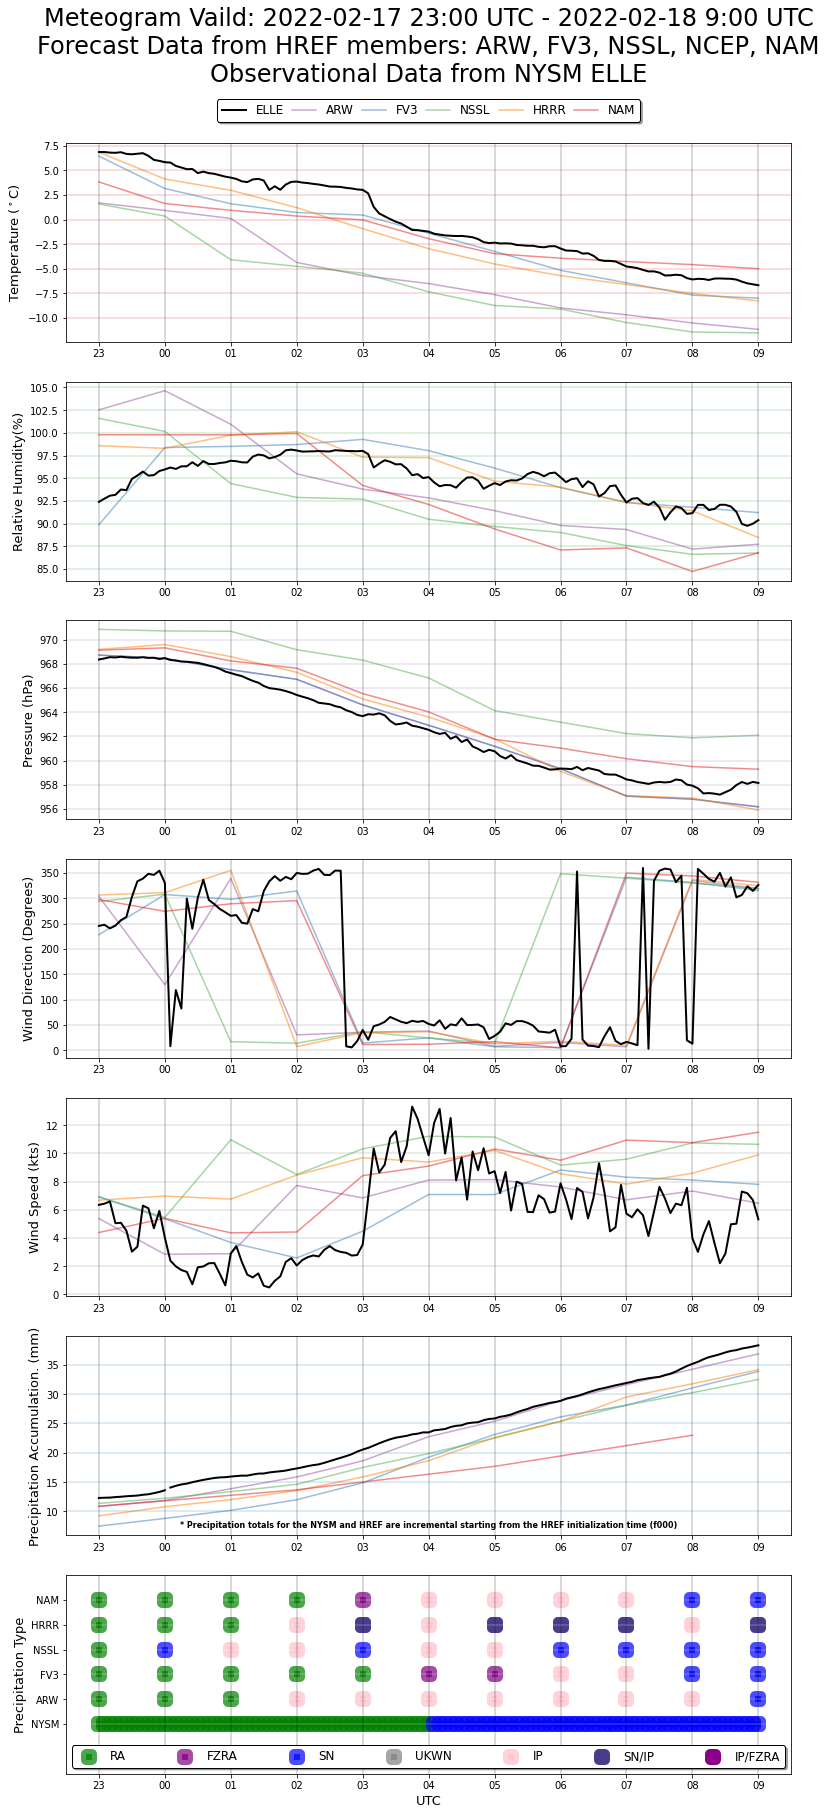

In [4]:
for i in nysmstation:
    
    ### NYSM Variables
    
    # NYSM Standard Products
    tmp = sdata['temp_2m'].sel(time=timerange,station = i)
    rlh = sdata['relative_humidity'].sel(time=timerange,station = i)
    prs = sdata['station_pressure'].sel(time=timerange,station = i)
    wds = sdata['wind_direction_sonic'].sel(time=timerange,station = i)# Sonic
    wss = sdata['avg_wind_speed_sonic'].sel(time=timerange,station = i)# Sonic
    dwp = tmp - ((100 - rlh)/5) # Dewpoint Derivation (if needed)
    wss = wss.metpy.convert_units('kts')
    
    # NYSM Precipitation
    reset_timerange = pd.date_range(start=reset_time,end=reset_time,freq='5min')
    post_reset_timerange = pd.date_range(start=return_time,end=endtime,freq='5min')
    reset_interval = pd.date_range(start=starttime,end=reset_time,freq='5min')
    pcl_reset = sdata['precip_local'].sel(time=reset_timerange,station = i)###########################
    pcl_interval = sdata['precip_local'].sel(time=post_reset_timerange,station = i)###########################
    pcl_begining = sdata['precip_local'].sel(time=reset_interval,station = i)###########################
    pcl_adjusted = pcl_interval.values + pcl_reset.values###########################
    
    # NYSM Winter Products
    fzra = wdata['ptype_freezing_rain'].sel(time_5M = timerange, station = i)
    ukwn = wdata['ptype_unknown'].sel(time_5M = timerange, station = i)
    rain = wdata['ptype_rain'].sel(time_5M = timerange, station = i)
    snow = wdata['ptype_snow'].sel(time_5M = timerange, station = i)

    ### Defining nearest grid point based on longitude and latitude of NYSM site of interest

    # WINTRE-MIX Relevant NYSM Stations
    if i == 'ESSX':
        station_lat = 44.313604
        station_lon = 286.628104
    elif i == 'ELLE':
        station_lat = 44.8955
        station_lon = 360 - 73.84502
    elif i == 'WFMB':
        station_lat = 44.393236
        station_lon = 360 - 73.858829
    elif i == 'GABR':
        station_lat = 44.41742
        station_lon = 360 - 74.17867
    elif i == 'LOUI':
        station_lat = 44.87169
        station_lon = 360 - 75.05608
    elif i == 'ELLE':
        station_lat = 44.8955
        station_lon = 360 - 73.84502
    elif i == 'EDWA':
        station_lat = 44.32177
        station_lon = 360 - 75.24413
    elif i == 'PHIL':
        station_lat = 44.19354
        station_lon = 360 - 75.71591
    elif i == 'POTS':
        station_lat = 44.656867
        station_lon = 360 - 74.974433
    elif i == 'TUPP':
        station_lat = 44.22128
        station_lon = 360 - 74.43826
    elif i == 'CAPE':
        station_lat = 44.10452
        station_lon = 360 - 76.32686
    elif i == 'MALO':
        station_lat = 44.852869
        station_lon = 360 - 74.328874
    elif i == 'CHAZ':
        station_lat = 44.89565
        station_lon = 286.53539
    elif i == 'NHUD':
        station_lat = 44.0131
        station_lon = 360 - 73.70516
    elif i == 'HAMM':
        station_lat = 44.51302
        station_lon = 360 - 75.61729 
    elif i == 'SARA':
        station_lat = 44.707585
        station_lon = 360 - 73.67115
    elif i == 'WELL':
        station_lat = 44.30782
        station_lon = 360 - 76.00858

    # Base Variable from a model to base coordinates off of
    with xr.open_mfdataset(arw, engine = 'cfgrib',
                         filter_by_keys={'stepType': 'instant', 'typeOfLevel': 'heightAboveGround', 'paramId':165},
                         concat_dim = 'valid_time',combine = 'nested') as arw_u10:
        arw_u10m = arw_u10['u10']*1.94384 #m s^-1 to knots

    #Get nearest gridpoint to station lat/lon
    def get_nearest_gridpoint(xlat, xlong, slat, slon, verbose = False):
        '''Get nearest gridpoint to 2D xarray DataArrays or numpy arrays of model gridpoint latitude and longitude (xlat, xlon),
        given an input lat/lon point (slat, slon)
        Adapted from example code by Brian Blaylock'''
        abslat = np.fabs(xlat-slat)
        abslon = np.fabs(xlong-slon)
        c = np.maximum(abslon, abslat)
        xyloc = np.where(c == np.min(c))
        xs, ys = xyloc[1][0], xyloc[0][0]
        #if verbose: print (f'nearest gridpoint to ({slat} N,{slon} E) is: {xs,ys}')
        return (xs, ys)

    gridpoints = get_nearest_gridpoint(arw_u10['latitude'],arw_u10['longitude'],station_lat,station_lon, verbose = True)# CHAZY
    station_x = gridpoints[0]
    station_y = gridpoints[1]
    
    print("Starting to load in ", i, " data...")
    
    # Deriving u wind data becasue we loaded it in early
    arw_uw = arw_u10m.sel(y = station_y , x = station_x).values
    arw_uw = np.float32(arw_uw) * units.knots
    arw_u10.close()
    arw_u10m.close()
    print("Base Variable")

    ### Variables

    # ARW 2m Temperature
    with xr.open_mfdataset(arw,engine = 'cfgrib',
                           filter_by_keys={'typeOfLevel': 'heightAboveGround','paramId':167},
                           concat_dim = 'valid_time',combine = 'nested') as arw_t2m:
        arw_temp2m = arw_t2m['t2m'] - 273.15 #K to degC  

    arw_tmp = arw_temp2m.sel(y = station_y , x = station_x).values
    arw_tmp = np.float32(arw_tmp) * units.degC
    arw_t2m.close()
    arw_temp2m.close()

    # FV3 2m Temperature
    with xr.open_mfdataset(fv3,engine = 'cfgrib',
                           filter_by_keys={'typeOfLevel': 'heightAboveGround','paramId':167},
                           concat_dim = 'valid_time',combine = 'nested') as fv3_t2m:
        fv3_temp2m = fv3_t2m['t2m'] - 273.15 #K to degC  

    fv3_tmp = fv3_temp2m.sel(y = station_y , x = station_x).values
    fv3_tmp = np.float32(fv3_tmp) * units.degC
    fv3_t2m.close()
    fv3_temp2m.close()

    # NSSL 2m Temperature
    with xr.open_mfdataset(nssl,engine = 'cfgrib',
                           filter_by_keys={'typeOfLevel': 'heightAboveGround','paramId':167},
                           concat_dim = 'valid_time',combine = 'nested') as nssl_t2m:
        nssl_temp2m = nssl_t2m['t2m'] - 273.15 #K to degC 

    nssl_tmp = nssl_temp2m.sel(y = station_y , x = station_x).values
    nssl_tmp = np.float32(nssl_tmp) * units.degC
    nssl_t2m.close()
    nssl_temp2m.close()

    # NCEP 2m Temperature
    with xr.open_mfdataset(ncep,engine = 'cfgrib',
                           filter_by_keys={'typeOfLevel': 'heightAboveGround','paramId':167},
                           concat_dim = 'valid_time',combine = 'nested') as ncep_t2m:
        ncep_temp2m = ncep_t2m['t2m'] - 273.15 #K to degC 

    ncep_tmp = ncep_temp2m.sel(y = station_y , x = station_x).values
    ncep_tmp = np.float32(ncep_tmp) * units.degC
    ncep_t2m.close()
    ncep_temp2m.close()

    # NEST 2m Temperature
    with xr.open_mfdataset(nam,engine = 'cfgrib',
                           filter_by_keys={'typeOfLevel': 'heightAboveGround','paramId':167},
                           concat_dim = 'valid_time',combine = 'nested') as nest_t2m:
        nest_temp2m = nest_t2m['t2m'] - 273.15 #K to degC

    nest_tmp = nest_temp2m.sel(y = station_y , x = station_x).values
    nest_tmp = np.float32(nest_tmp) * units.degC
    nest_t2m.close()
    nest_temp2m.close()
    print("2m Temperature")

    # ARW 2m Dewpoint
    with xr.open_mfdataset(arw,engine = 'cfgrib',
                           filter_by_keys={'typeOfLevel': 'heightAboveGround','paramId':168},
                           concat_dim = 'valid_time',combine = 'nested') as arw_d2m:
        arw_dewp2m = arw_d2m['d2m'] - 273.15 #K to degC

    arw_dwp = arw_dewp2m.sel(y = station_y , x = station_x).values
    arw_dwp = np.float32(arw_dwp) * units.degC
    arw_d2m.close()
    arw_dewp2m.close()

    # FV3 2m Dewpoint
    with xr.open_mfdataset(fv3,engine = 'cfgrib',
                           filter_by_keys={'typeOfLevel': 'heightAboveGround','paramId':168},
                           concat_dim = 'valid_time',combine = 'nested') as fv3_d2m:
        fv3_dewp2m = fv3_d2m['d2m'] - 273.15 #K to degC

    fv3_dwp = fv3_dewp2m.sel(y = station_y , x = station_x).values
    fv3_dwp = np.float32(fv3_dwp) * units.degC
    fv3_d2m.close()
    fv3_dewp2m.close()

    # NSSL 2m Dewpoint
    with xr.open_mfdataset(nssl,engine = 'cfgrib',
                           filter_by_keys={'typeOfLevel': 'heightAboveGround','paramId':168},
                           concat_dim = 'valid_time',combine = 'nested') as nssl_d2m:
        nssl_dewp2m = nssl_d2m['d2m'] - 273.15 #K to degC

    nssl_dwp = nssl_dewp2m.sel(y = station_y , x = station_x).values
    nssl_dwp = np.float32(nssl_dwp) * units.degC
    nssl_d2m.close()
    nssl_dewp2m.close()

    # NCEP 2m Dewpoint
    with xr.open_mfdataset(ncep,engine = 'cfgrib',
                           filter_by_keys={'typeOfLevel': 'heightAboveGround','paramId':168},
                           concat_dim = 'valid_time',combine = 'nested') as ncep_d2m:
        ncep_dewp2m = ncep_d2m['d2m'] - 273.15 #K to degC

    ncep_dwp = ncep_dewp2m.sel(y = station_y , x = station_x).values
    ncep_dwp = np.float32(ncep_dwp) * units.degC
    ncep_d2m.close()
    ncep_dewp2m.close()

    # NEST 2m Dewpoint
    with xr.open_mfdataset(nam,engine = 'cfgrib',
                           filter_by_keys={'typeOfLevel': 'heightAboveGround','paramId':168},
                           concat_dim = 'valid_time',combine = 'nested') as nest_d2m:
        nest_dewp2m = nest_d2m['d2m'] - 273.15 #K to degC

    nest_dwp = nest_dewp2m.sel(y = station_y , x = station_x).values
    nest_dwp = np.float32(nest_dwp) * units.degC
    nest_d2m.close()
    nest_dewp2m.close()
    print("2m Dewpoint")

    # ARW Pressure
    with xr.open_mfdataset(arw,engine = 'cfgrib',
                           filter_by_keys={'typeOfLevel': 'surface','paramId':134},
                           concat_dim = 'valid_time',combine = 'nested') as arw_pa:
        arw_press = arw_pa['sp'] *.01 #Pa to hPa

    arw_pre = arw_press.sel(y = station_y ,x = station_x).values
    arw_pre = np.float32(arw_pre)
    arw_pa.close()
    arw_press.close()

    # FV3 Pressure
    with xr.open_mfdataset(fv3,engine = 'cfgrib',
                           filter_by_keys={'typeOfLevel': 'surface','paramId':134},
                           concat_dim = 'valid_time',combine = 'nested') as fv3_pa:
        fv3_press = fv3_pa['sp'] *.01 #Pa to hPa

    fv3_pre = arw_press.sel(y = station_y , x = station_x).values
    fv3_pre = np.float32(fv3_pre)
    fv3_pa.close()
    fv3_press.close()

    # NSSL Pressure
    with xr.open_mfdataset(nssl,engine = 'cfgrib',
                           filter_by_keys={'typeOfLevel': 'surface','paramId':134},
                           concat_dim = 'valid_time',combine = 'nested') as nssl_pa:
        nssl_press = nssl_pa['sp'] *.01 #Pa to hPa

    nssl_pre = nssl_press.sel(y = station_y , x = station_x).values
    nssl_pre = np.float32(nssl_pre)
    nssl_pa.close()
    nssl_press.close()

    # NCEP Pressure
    with xr.open_mfdataset(ncep,engine = 'cfgrib',
                           filter_by_keys={'typeOfLevel': 'surface','paramId':134},
                           concat_dim = 'valid_time',combine = 'nested') as ncep_pa:
        ncep_press = ncep_pa['sp'] *.01 #Pa to hPa

    ncep_pre = ncep_press.sel(y = station_y , x = station_x).values
    ncep_pre = np.float32(ncep_pre)
    ncep_pa.close()
    ncep_press.close()

    # NEST Pressure
    with xr.open_mfdataset(nam,engine = 'cfgrib',
                           filter_by_keys={'typeOfLevel': 'surface','paramId':134},
                           concat_dim = 'valid_time',combine = 'nested') as nest_pa:
        nest_press = nest_pa['sp'] *.01 #Pa to hPa

    nest_pre = nest_press.sel(y = station_y , x = station_x).values
    nest_pre = np.float32(nest_pre)
    nest_pa.close()
    nest_press.close()
    print("Pressure")

    # ARW 10m Uwind component

    # USED FOR GEOLOCATION EARLIER!

    # FV3 10m Uwind component
    with xr.open_mfdataset(fv3, engine = 'cfgrib',
                         filter_by_keys={'stepType': 'instant', 'typeOfLevel': 'heightAboveGround', 'paramId':165},
                         concat_dim = 'valid_time',combine = 'nested') as fv3_u10:
        fv3_u10m = fv3_u10['u10']*1.94384 #m s^-1 to knots

    fv3_uw = fv3_u10m.sel(y = station_y , x = station_x).values
    fv3_uw = np.float32(fv3_uw) * units.knots
    fv3_u10.close()
    fv3_u10m.close()

    # NSSL 10m Uwind component
    with xr.open_mfdataset(nssl, engine = 'cfgrib',
                         filter_by_keys={'stepType': 'instant', 'typeOfLevel': 'heightAboveGround', 'paramId':165},
                         concat_dim = 'valid_time',combine = 'nested') as nssl_u10:
        nssl_u10m = nssl_u10['u10']*1.94384 #m s^-1 to knots

    nssl_uw = nssl_u10m.sel(y = station_y , x = station_x).values
    nssl_uw = np.float32(nssl_uw) * units.knots
    nssl_u10.close()
    nssl_u10m.close()

    # NCEP 10m Uwind component
    with xr.open_mfdataset(ncep, engine = 'cfgrib',
                         filter_by_keys={'stepType': 'instant', 'typeOfLevel': 'heightAboveGround', 'paramId':165},
                         concat_dim = 'valid_time',combine = 'nested') as ncep_u10:
        ncep_u10m = ncep_u10['u10']*1.94384 #m s^-1 to knots

    ncep_uw = ncep_u10m.sel(y = station_y , x = station_x).values
    ncep_uw = np.float32(ncep_uw) * units.knots
    ncep_u10.close()
    ncep_u10m.close()

    # NEST 10m Uwind component
    with xr.open_mfdataset(nam, engine = 'cfgrib',
                         filter_by_keys={'stepType': 'instant', 'typeOfLevel': 'heightAboveGround', 'paramId':165},
                         concat_dim = 'valid_time',combine = 'nested') as nest_u10:
        nest_u10m = nest_u10['u10']*1.94384 #m s^-1 to knots

    nest_uw = nest_u10m.sel(y = station_y , x = station_x).values
    nest_uw = np.float32(nest_uw) * units.knots
    nest_u10.close()
    nest_u10m.close()
    print("10m Wind (U)")

    # ARW 10m Vwind component
    with xr.open_mfdataset(arw, engine = 'cfgrib',
                         filter_by_keys={'stepType': 'instant', 'typeOfLevel': 'heightAboveGround', 'paramId':166},
                         concat_dim = 'valid_time',combine = 'nested') as arw_v10:
        arw_v10m = arw_v10['v10']*1.94384 #m s^-1 to knots

    arw_vw = arw_v10m.sel(y = station_y , x = station_x).values
    arw_vw = np.float32(arw_vw) * units.knots
    arw_v10.close()
    arw_v10m.close()

    # FV3 10m Vwind component
    with xr.open_mfdataset(fv3, engine = 'cfgrib',
                         filter_by_keys={'stepType': 'instant', 'typeOfLevel': 'heightAboveGround', 'paramId':166},
                         concat_dim = 'valid_time',combine = 'nested') as fv3_v10:
        fv3_v10m = fv3_v10['v10']*1.94384 #m s^-1 to knots

    fv3_vw = fv3_v10m.sel(y = station_y , x = station_x).values
    fv3_vw = np.float32(fv3_vw) * units.knots
    fv3_v10.close()
    fv3_v10m.close()

    # NSSL 10m Vwind component
    with xr.open_mfdataset(nssl, engine = 'cfgrib',
                         filter_by_keys={'stepType': 'instant', 'typeOfLevel': 'heightAboveGround', 'paramId':166},
                         concat_dim = 'valid_time',combine = 'nested') as nssl_v10:
        nssl_v10m = nssl_v10['v10']*1.94384 #m s^-1 to knots

    nssl_vw = nssl_v10m.sel(y = station_y , x = station_x).values
    nssl_vw = np.float32(nssl_vw) * units.knots
    nssl_v10.close()
    nssl_v10m.close()

    # NCEP 10m Vwind component
    with xr.open_mfdataset(ncep, engine = 'cfgrib',
                         filter_by_keys={'stepType': 'instant', 'typeOfLevel': 'heightAboveGround', 'paramId':166},
                         concat_dim = 'valid_time',combine = 'nested') as ncep_v10:
        ncep_v10m = ncep_v10['v10']*1.94384 #m s^-1 to knots

    ncep_vw = ncep_v10m.sel(y = station_y , x = station_x).values
    ncep_vw = np.float32(ncep_vw) * units.knots
    ncep_v10.close()
    ncep_v10m.close()

    # NEST 10m Vwind component
    with xr.open_mfdataset(nam, engine = 'cfgrib',
                         filter_by_keys={'stepType': 'instant', 'typeOfLevel': 'heightAboveGround', 'paramId':166},
                         concat_dim = 'valid_time',combine = 'nested') as nest_v10:
        nest_v10m = nest_v10['v10']*1.94384 #m s^-1 to knots

    nest_vw = nest_v10m.sel(y = station_y , x = station_x).values
    nest_vw = np.float32(nest_vw) * units.knots
    nest_v10.close()
    nest_v10m.close()
    print("10m Wind (V)")

    # ARW Total Precipitation
    with xr.open_mfdataset(arw,engine = 'cfgrib',filter_by_keys={'stepType': 'accum','typeOfLevel': 'surface','paramId':228228},concat_dim = 'valid_time',combine = 'nested') as arw_fc:
        arw_totp = arw_fc['tp'] 
        arw_pcp = arw_totp.sel(y = station_y , x = station_x).values
        arw_pcp = np.float32(arw_pcp)
        arw_fc.close
        arw_totp.close

    # FV3 "Front End" Total Precipitation
    with xr.open_mfdataset(fv3adj,engine = 'cfgrib',filter_by_keys={'stepType': 'accum','typeOfLevel': 'surface','paramId':228228},concat_dim = 'valid_time',combine = 'nested') as fv3adj_fc:
        fv3_totpadj = fv3adj_fc['tp']
        fv3_pcpadj = fv3_totpadj.sel(y = station_y , x = station_x).values
        fv3_pcpadj = np.float32(fv3_pcpadj)
        fv3_pcpadj = np.sum(fv3_pcpadj)
    
    # FV3 Total Precipitation
    with xr.open_mfdataset(fv3,engine = 'cfgrib',filter_by_keys={'stepType': 'accum','typeOfLevel': 'surface','paramId':228228},concat_dim = 'valid_time',combine = 'nested') as fv3_fc:
        fv3_totp = fv3_fc['tp']
        fv3_pcp = fv3_totp.sel(y = station_y , x = station_x).values
        fv3_pcp = np.float32(fv3_pcp)
        fv3_pcp = np.cumsum(fv3_pcp)
        fv3_pcp = fv3_pcp + fv3_pcpadj
        fv3_fc.close
        fv3_totp.close

    # NSSL Total Precipitation
    with xr.open_mfdataset(nssl,engine = 'cfgrib',filter_by_keys={'stepType': 'accum','typeOfLevel': 'surface','paramId':228228},concat_dim = 'valid_time',combine = 'nested') as nssl_fc:
        nssl_totp = nssl_fc['tp'] 
        nssl_pcp = nssl_totp.sel(y = station_y , x = station_x).values
        nssl_pcp = np.float32(nssl_pcp)
        nssl_fc.close
        nssl_totp.close

    # NCEP Total Precipitation
    with xr.open_mfdataset(ncep,engine = 'cfgrib',filter_by_keys={'stepType': 'accum','typeOfLevel': 'surface','paramId':228228},concat_dim = 'valid_time',combine = 'nested') as ncep_fc:
        ncep_totp = ncep_fc['tp']
        ncep_pcp = ncep_totp.sel(y = station_y , x = station_x).values
        ncep_pcp = np.float32(ncep_pcp)
        ncep_fc.close
        ncep_totp.close

    # NAM "Front End" Total Precipitation
    with xr.open_mfdataset(namadj[0:100:3],engine = 'cfgrib',filter_by_keys={'stepType': 'accum','typeOfLevel': 'surface','paramId':228228},concat_dim = 'valid_time',combine = 'nested') as namadj_fc:
        nam_totpadj = namadj_fc['tp']
        nam_pcpadj = nam_totpadj.sel(y = station_y , x = station_x).values
        nam_pcpadj = np.float32(nam_pcpadj)
        nam_pcpadj = np.sum(nam_pcpadj)
        
    # NAM Total Precipitation
    with xr.open_mfdataset(nam[0:100:3],engine = 'cfgrib',filter_by_keys={'stepType': 'accum','typeOfLevel': 'surface','paramId':228228},concat_dim = 'valid_time',combine = 'nested') as nest_fc:
        nest_totp = nest_fc['tp']
        nest_pcp = nest_totp.sel(y = station_y , x = station_x).values
        nest_pcp = np.float32(nest_pcp)
        nest_pcp = np.cumsum(nest_pcp)
        nest_pcp = nest_pcp + nam_pcpadj
        nest_fc.close
        nest_totp.close
        print("Total Precipitation")

    # ARW Catagorical Rain
    with xr.open_mfdataset(arw,engine = 'cfgrib',
                           filter_by_keys={'stepType': 'instant','typeOfLevel': 'surface','paramId':260029},
                           concat_dim = 'valid_time',combine = 'nested') as arw_cr:
        arw_rain = arw_cr['crain']

    arw_rainin = arw_rain.sel(y = station_y , x = station_x).values
    arw_rainin = np.float32(arw_rainin)
    arw_cr.close()
    arw_rain.close()

    # FV3 Catagorical Rain   
    with xr.open_mfdataset(fv3,engine = 'cfgrib',
                           filter_by_keys={'stepType': 'instant','typeOfLevel': 'surface','paramId':260029},
                           concat_dim = 'valid_time',combine = 'nested') as fv3_cr:
        fv3_rain = fv3_cr['crain']

    fv3_rainin = fv3_rain.sel(y = station_y , x = station_x).values
    fv3_rainin = np.float32(fv3_rainin)
    fv3_cr.close()
    fv3_rain.close()

    # NSSL Catagorical Rain
    with xr.open_mfdataset(nssl,engine = 'cfgrib',
                           filter_by_keys={'stepType': 'instant','typeOfLevel': 'surface','paramId':260029},
                           concat_dim = 'valid_time',combine = 'nested') as nssl_cr:
        nssl_rain = nssl_cr['crain']

    nssl_rainin = nssl_rain.sel(y = station_y , x = station_x).values
    nssl_rainin = np.float32(nssl_rainin)
    nssl_cr.close()
    nssl_rain.close()

    # NCEP Catagorical Rain   
    with xr.open_mfdataset(ncep,engine = 'cfgrib',
                           filter_by_keys={'stepType': 'instant','typeOfLevel': 'surface','paramId':260029},
                           concat_dim = 'valid_time',combine = 'nested') as ncep_cr:
        ncep_rain = ncep_cr['crain']

    ncep_rainin = ncep_rain.sel(y = station_y , x = station_x).values
    ncep_rainin = np.float32(ncep_rainin)
    ncep_cr.close()
    ncep_rain.close()

    # NEST Catagorical Rain   
    with xr.open_mfdataset(nam,engine = 'cfgrib',
                           filter_by_keys={'stepType': 'instant','typeOfLevel': 'surface','paramId':260029},
                           concat_dim = 'valid_time',combine = 'nested') as nest_cr:
        nest_rain = nest_cr['crain']

    nest_rainin = nest_rain.sel(y = station_y , x = station_x).values
    nest_rainin = np.float32(nest_rainin)
    nest_cr.close()
    nest_rain.close()
    print("Catagorical Rain")

    # ARW Catagorical Freezing Rain
    with xr.open_mfdataset(arw,engine = 'cfgrib',
                           filter_by_keys={'stepType': 'instant','typeOfLevel': 'surface','paramId':260030},
                           concat_dim = 'valid_time',combine = 'nested') as arw_cf:
        arw_fzra = arw_cf['cfrzr']

    arw_fzrara = arw_fzra.sel(y = station_y , x = station_x).values
    arw_fzrara = np.float32(arw_fzrara)
    arw_cf.close()
    arw_fzra.close()

    # FV3 Catagorical Freezing Rain   
    with xr.open_mfdataset(fv3,engine = 'cfgrib',
                           filter_by_keys={'stepType': 'instant','typeOfLevel': 'surface','paramId':260030},
                           concat_dim = 'valid_time',combine = 'nested') as fv3_cf:
        fv3_fzra = fv3_cf['cfrzr']

    fv3_fzrara = fv3_fzra.sel(y = station_y , x = station_x).values
    fv3_fzrara = np.float32(fv3_fzrara)
    fv3_cf.close()
    fv3_fzra.close()

    # NSSL Catagorical Freezing Rain
    with xr.open_mfdataset(nssl,engine = 'cfgrib',
                           filter_by_keys={'stepType': 'instant','typeOfLevel': 'surface','paramId':260030},
                           concat_dim = 'valid_time',combine = 'nested') as nssl_cf:
        nssl_fzra = nssl_cf['cfrzr']

    nssl_fzrara = nssl_fzra.sel(y = station_y , x = station_x).values
    nssl_fzrara = np.float32(nssl_fzrara)
    nssl_cf.close()
    nssl_fzra.close()

    # NCEP Catagorical Freezing Rain   
    with xr.open_mfdataset(ncep,engine = 'cfgrib',
                           filter_by_keys={'stepType': 'instant','typeOfLevel': 'surface','paramId':260030},
                           concat_dim = 'valid_time',combine = 'nested') as ncep_cf:
        ncep_fzra = ncep_cf['cfrzr']

    ncep_fzrara = ncep_fzra.sel(y = station_y , x = station_x).values
    ncep_fzrara = np.float32(ncep_fzrara)
    ncep_cf.close()
    ncep_fzra.close()

    # NEST Catagorical Freezing Rain   
    with xr.open_mfdataset(nam,engine = 'cfgrib',
                           filter_by_keys={'stepType': 'instant','typeOfLevel': 'surface','paramId':260030},
                           concat_dim = 'valid_time',combine = 'nested') as nest_cf:
        nest_fzra = nest_cf['cfrzr']

    nest_fzrara = nest_fzra.sel(y = station_y , x = station_x).values
    nest_fzrara = np.float32(nest_fzrara)
    nest_cf.close()
    nest_fzra.close()
    print("Catagorical Freezing Rain")

    # ARW Catagorical Ice Pellets
    with xr.open_mfdataset(arw,engine = 'cfgrib',
                           filter_by_keys={'stepType': 'instant','typeOfLevel': 'surface','paramId':260031},
                           concat_dim = 'valid_time',combine = 'nested') as arw_ip:
        arw_icep = arw_ip['cicep']

    arw_icepep = arw_icep.sel(y = station_y , x = station_x).values
    arw_icepep = np.float32(arw_icepep)
    arw_ip.close()
    arw_icep.close()

    # FV3 Catagorical Ice Pellets  
    with xr.open_mfdataset(fv3,engine = 'cfgrib',
                           filter_by_keys={'stepType': 'instant','typeOfLevel': 'surface','paramId':260031},
                           concat_dim = 'valid_time',combine = 'nested') as fv3_ip:
        fv3_icep = fv3_ip['cicep']

    fv3_icepep = fv3_icep.sel(y = station_y , x = station_x).values
    fv3_icepep = np.float32(fv3_icepep)
    fv3_ip.close()
    fv3_icep.close()

    # NSSL Catagorical Ice Pellets
    with xr.open_mfdataset(nssl,engine = 'cfgrib',
                           filter_by_keys={'stepType': 'instant','typeOfLevel': 'surface','paramId':260031},
                           concat_dim = 'valid_time',combine = 'nested') as nssl_ip:
        nssl_icep = nssl_ip['cicep']

    nssl_icepep = nssl_icep.sel(y = station_y , x = station_x).values
    nssl_icepep = np.float32(nssl_icepep)
    nssl_ip.close()
    nssl_icep.close()

    # NCEP Catagorical Ice Pellets  
    with xr.open_mfdataset(ncep,engine = 'cfgrib',
                           filter_by_keys={'stepType': 'instant','typeOfLevel': 'surface','paramId':260031},
                           concat_dim = 'valid_time',combine = 'nested') as ncep_ip:
        ncep_icep = ncep_ip['cicep']

    ncep_icepep = ncep_icep.sel(y = station_y , x = station_x).values
    ncep_icepep = np.float32(ncep_icepep)
    ncep_ip.close()
    ncep_icep.close()

    # NEST Catagorical Ice Pellets  
    with xr.open_mfdataset(nam,engine = 'cfgrib',
                           filter_by_keys={'stepType': 'instant','typeOfLevel': 'surface','paramId':260031},
                           concat_dim = 'valid_time',combine = 'nested') as nest_ip:
        nest_icep = nest_ip['cicep']

    nest_icepep = nest_icep.sel(y = station_y , x = station_x).values
    nest_icepep = np.float32(nest_icepep)
    nest_ip.close()
    nest_icep.close()
    print("Catagorical Ice Pellets")

    # ARW Catagorical Snow
    with xr.open_mfdataset(arw,engine = 'cfgrib',
                           filter_by_keys={'stepType': 'instant','typeOfLevel': 'surface','paramId':260032},
                           concat_dim = 'valid_time',combine = 'nested') as arw_sn:
        arw_snow = arw_sn['csnow']

    arw_snowsn = arw_snow.sel(y = station_y , x = station_x).values
    arw_snowsn = np.float32(arw_snowsn)
    arw_sn.close()
    arw_snow.close()

    # FV3 Catagorical Snow  
    with xr.open_mfdataset(fv3,engine = 'cfgrib',
                           filter_by_keys={'stepType': 'instant','typeOfLevel': 'surface','paramId':260032},
                           concat_dim = 'valid_time',combine = 'nested') as fv3_sn:
        fv3_snow = fv3_sn['csnow']

    fv3_snowsn = fv3_snow.sel(y = station_y , x = station_x).values
    fv3_snowsn = np.float32(fv3_snowsn)
    fv3_sn.close()
    fv3_snow.close()

    # NSSL Catagorical Snow
    with xr.open_mfdataset(nssl,engine = 'cfgrib',
                           filter_by_keys={'stepType': 'instant','typeOfLevel': 'surface','paramId':260032},
                           concat_dim = 'valid_time',combine = 'nested') as nssl_sn:
        nssl_snow = nssl_sn['csnow']

    nssl_snowsn = nssl_snow.sel(y = station_y , x = station_x).values
    nssl_snowsn = np.float32(nssl_snowsn)
    nssl_sn.close()
    nssl_snow.close()

    # NCEP Catagorical Snow  
    with xr.open_mfdataset(ncep,engine = 'cfgrib',
                           filter_by_keys={'stepType': 'instant','typeOfLevel': 'surface','paramId':260032},
                           concat_dim = 'valid_time',combine = 'nested') as ncep_sn:
        ncep_snow = ncep_sn['csnow']

    ncep_snowsn = ncep_snow.sel(y = station_y , x = station_x).values
    ncep_snowsn = np.float32(ncep_snowsn)
    ncep_sn.close()
    ncep_snow.close()

    # NCEP Catagorical Snow  
    with xr.open_mfdataset(nam,engine = 'cfgrib',
                           filter_by_keys={'stepType': 'instant','typeOfLevel': 'surface','paramId':260032},
                           concat_dim = 'valid_time',combine = 'nested') as nest_sn:
        nest_snow = nest_sn['csnow']

    nest_snowsn = nest_snow.sel(y = station_y , x = station_x).values
    nest_snowsn = np.float32(nest_snowsn)
    nest_sn.close()
    nest_snow.close()
    print("Catagorical Snow")
    
    print("Done loading in ", i, " data...")

    # Wind Speed
    arw_ws = wind_speed(arw_uw,arw_vw)
    fv3_ws = wind_speed(fv3_uw,fv3_vw)
    nssl_ws = wind_speed(nssl_uw,nssl_vw)
    ncep_ws = wind_speed(ncep_uw,ncep_vw)
    nest_ws = wind_speed(nest_uw,nest_vw)

    # Wind Direction
    arw_wd = wind_direction(arw_uw,arw_vw,convention = 'from')
    fv3_wd = wind_direction(fv3_uw,fv3_vw,convention = 'from')
    nssl_wd = wind_direction(nssl_uw,nssl_vw,convention = 'from')
    ncep_wd = wind_direction(ncep_uw,ncep_vw,convention = 'from')
    nest_wd = wind_direction(nest_uw,nest_vw,convention = 'from')

    # Relative Humidity
    arw_rh = relative_humidity_from_dewpoint(arw_tmp, arw_dwp)*100
    fv3_rh = relative_humidity_from_dewpoint(fv3_tmp, fv3_dwp)*100
    nssl_rh = relative_humidity_from_dewpoint(nssl_tmp, nssl_dwp)*100
    ncep_rh = relative_humidity_from_dewpoint(ncep_tmp, ncep_dwp)*100
    nest_rh = relative_humidity_from_dewpoint(nest_tmp, nest_dwp)*100
    
    # PTYPE Combinations (HRRR ONLY)
    ncep_icep_snow = np.add(ncep_icepep,ncep_snowsn)###########################
    ncep_icep_fzra = np.add(ncep_icepep,ncep_fzrara)###########################
    ncep_rain_snow = np.add(ncep_rainin,ncep_snowsn)###########################
    ncep_rain_icep = np.add(ncep_rainin,ncep_icepep)###########################
    
    def features(ax):
        ax.grid(color='black',linewidth=0.3)
        ax.xaxis.set_major_formatter(dateFmt)
        ax.xaxis.set_major_locator(HourLocator(interval=1))
        ax.xaxis.set_minor_locator(HourLocator(interval=1))
        # X-Axis Formating 
    dateFmt = DateFormatter('%H')

    # Title Formating
    tl1 = "Meteogram Vaild: "+ starttime + ' UTC - ' + endtime + ' UTC'
    tl3 = "Observational Data from NYSM " + i
    tl2 = "Forecast Data from HREF members: ARW, FV3, NSSL, NCEP, NAM"
    title_line = (tl1 + '\n' + tl2 + '\n' + tl3 + '\n' + '\n')
    savefiguretitle = yyyymmddhh_str + '_meteogram_' + i

    # Line colors of each model
    lc1 = '#984ea3'
    lc2 = '#377eb8'
    lc3 = '#4daf4a'
    lc4 = '#ff7f00'
    lc5 = '#e41a1c'

    # Main Figure 
    fig = plt.figure(figsize=(13,30))
    fig.tight_layout()
    
    # Temperature
    ax = fig.add_subplot(7,1,1)
    plt.title(title_line, fontsize = 24) # TITLE FOR FIGURE
    features(ax)
    ax.plot (timerange, tmp, color = 'black', label = i, linewidth = 2, zorder = 5)
    ax.plot (timerange_HREF, arw_tmp, color = lc1, label = 'ARW', zorder = 1, alpha = 0.5)
    ax.plot (timerange_HREF, fv3_tmp, color = lc2, label = 'FV3', zorder = 1, alpha = 0.5)
    ax.plot (timerange_HREF, nssl_tmp, color = lc3, label = 'NSSL', zorder = 1, alpha = 0.5)
    ax.plot (timerange_HREF, ncep_tmp, color = lc4, label = 'HRRR', zorder = 1, alpha = 0.5)
    ax.plot (timerange_HREF, nest_tmp, color = lc5, label = 'NAM', zorder = 1, alpha = 0.5)
    ax.tick_params(which='major',axis='y',direction='out', grid_color= 'tab:red')
    ax.set_ylabel ('Temperature ($^\circ$C)', fontsize = 13)
    #ax.legend(loc='lower right',frameon=True,bbox_transform=ax.transAxes,fontsize=10,shadow=True,edgecolor='black')
    ax.legend(loc='upper center',frameon=True,fontsize=12,shadow = True,edgecolor = 'black',mode = "expand", ncol = 6,bbox_to_anchor=(0.20, -.05, 0.6,1.3))

    # Dewpoint
    ax = fig.add_subplot(7,1,2)
    features(ax)
    ax.plot (timerange, rlh, color = 'black', label = i, linewidth = 2, zorder = 5)
    ax.plot (timerange_HREF, arw_rh, color = lc1, label = 'ARW', zorder = 1, alpha = 0.5)
    ax.plot (timerange_HREF, fv3_rh, color = lc2, label = 'FV3', zorder = 1, alpha = 0.5)
    ax.plot (timerange_HREF, nssl_rh, color = lc3, label = 'NSSL', zorder = 1, alpha = 0.5)
    ax.plot (timerange_HREF, ncep_rh, color = lc4, label = 'HRRR', zorder = 1, alpha = 0.5)
    ax.plot (timerange_HREF, nest_rh, color = lc5, label = 'NAM', zorder = 1, alpha = 0.5)
    ax.tick_params(which='major',axis='y',direction='out', grid_color= 'tab:green')
    ax.set_ylabel ('Relative Humidity(%)', fontsize = 13)

    # Pressure
    ax = fig.add_subplot(7,1,3)
    features(ax)
    ax.set_ylabel ('Pressure (hPa)', fontsize = 13)
    ax.plot (timerange, prs, color = 'black', label = i, linewidth = 2, zorder = 5)
    ax.plot (timerange_HREF, arw_pre, color = lc1, label = 'ARW', zorder = 1, alpha = .5)
    ax.plot (timerange_HREF, fv3_pre, color = lc2, label = 'FV3', zorder = 1, alpha = .5)
    ax.plot (timerange_HREF, nssl_pre, color = lc3, label = 'NSSL', zorder = 1, alpha = 0.5)
    ax.plot (timerange_HREF, ncep_pre, color = lc4, label = 'HRRR', zorder = 1, alpha = 0.5)
    ax.plot (timerange_HREF, nest_pre, color = lc5, label = 'NAM', zorder = 1, alpha = 0.5)
    ax.tick_params(which='major',axis='y',direction='out', grid_color= 'tab:purple')

    # Wind Direction

    ax = fig.add_subplot(7,1,4)
    features(ax)
    ax.plot (timerange, wds, color = 'black', label = i, linewidth = 2, zorder = 5)
    ax.plot (timerange_HREF, arw_wd, color = lc1, label = 'ARW', zorder = 1, alpha = 0.5)
    ax.plot (timerange_HREF, fv3_wd, color = lc2, label = 'FV3', zorder = 1, alpha = 0.5)
    ax.plot (timerange_HREF, nssl_wd, color = lc3, label = 'NSSL', zorder = 1, alpha = 0.5)
    ax.plot (timerange_HREF, ncep_wd, color = lc4, label = 'HRRR', zorder = 1, alpha = 0.5)
    ax.plot (timerange_HREF, nest_wd, color = lc5, label = 'NAM', zorder = 1, alpha = 0.5)
    ax.set_ylabel ('Wind Direction (Degrees)', fontsize = 13)
    ax.tick_params(which='major',axis='y',direction='out', grid_color= 'tab:gray')

    # Wind Speed
    ax = fig.add_subplot(7,1,5)
    features(ax)
    ax.plot (timerange, wss, color = 'black', label = i, linewidth = 2, zorder = 5)
    ax.plot (timerange_HREF, arw_ws, color = lc1, label = 'ARW', zorder = 1, alpha = 0.5)
    ax.plot (timerange_HREF, fv3_ws, color = lc2, label = 'FV3', zorder = 1, alpha = 0.5)
    ax.plot (timerange_HREF, nssl_ws, color = lc3, label = 'NSSL', zorder = 1, alpha = 0.5)
    ax.plot (timerange_HREF, ncep_ws, color = lc4, label = 'HRRR', zorder = 1, alpha = 0.5)
    ax.plot (timerange_HREF, nest_ws, color = lc5, label = 'NAM', zorder = 1, alpha = 0.5)
    ax.set_ylabel ('Wind Speed (kts)', fontsize = 13)
    ax.tick_params(which='major',axis='y',direction='out', grid_color= 'tab:gray')

    # Precipitation Accumulation
    ax = fig.add_subplot(7,1,6)
    features(ax)    
    ax.plot (reset_interval,pcl_begining, color = 'black', label = i, linewidth = 2, zorder = 5)
    ax.plot (post_reset_timerange,pcl_adjusted, color = 'black', linewidth = 2, zorder = 5)
    ax.plot (timerange_HREF, arw_pcp, color = lc1, label = 'ARW', zorder = 1, alpha = 0.5)
    ax.plot (timerange_HREF, fv3_pcp, color = lc2, label = 'FV3', zorder = 1, alpha = 0.5)
    ax.plot (timerange_HREF, nssl_pcp, color = lc3, label = 'NSSL', zorder = 1, alpha = 0.5)
    ax.plot (timerange_HREF, ncep_pcp, color = lc4, label = 'HRRR', zorder = 1, alpha = 0.5)
    ax.plot (timerange_HREF_NAM, nest_pcp, color = lc5, label = 'NAM', zorder = 1, alpha = 0.5)
    ax.tick_params(which='major',axis='y',direction='out', grid_color= 'tab:blue')
    ax.set_ylabel ('Precipitation Accumulation. (mm)', fontsize = 13)
    
    # Precipitation Type
    ax = fig.add_subplot(7,1,7) 
    features(ax)
    ax.set_title('* Precipitation totals for the NYSM and HREF are incremental starting from the HREF initialization time (f000)'+ '\n'+'\n'+ '\n' + '\n',
            fontsize = 8, fontweight = 'bold')
    ax.scatter (timerange, rain, marker = 's', color = 'green', linewidth = 10, alpha = .7, label = 'RA')
    ax.scatter (timerange, fzra, marker = 's', color = 'purple', linewidth = 10, alpha = .7, label = 'FZRA')
    ax.scatter (timerange, snow, marker = 's', color = 'blue', linewidth = 10, alpha = .7, label = 'SN')
    ax.scatter (timerange, ukwn, marker = 's', color = 'gray', linewidth = 10, alpha = .7, label = 'UKWN')
    ax.scatter (timerange_HREF, arw_rainin +.1, marker = 's', color = 'green', linewidth = 10, alpha = .7) 
    ax.scatter (timerange_HREF, arw_fzrara +.1, marker = 's', color = 'purple', linewidth = 10, alpha = .7)
    ax.scatter (timerange_HREF, arw_snowsn +.1, marker = 's', color = 'blue', linewidth = 10, alpha = .7)
    ax.scatter (timerange_HREF, arw_icepep +.1, marker = 's', color = 'pink', linewidth = 10, alpha = .7, label = 'IP')
    ax.scatter (timerange_HREF, fv3_rainin +.2, marker = 's', color = 'green', linewidth = 10, alpha = .7)
    ax.scatter (timerange_HREF, fv3_fzrara +.2, marker = 's', color = 'purple', linewidth = 10, alpha = .7)
    ax.scatter (timerange_HREF, fv3_snowsn +.2, marker = 's', color = 'blue', linewidth = 10, alpha = .7)
    ax.scatter (timerange_HREF, fv3_icepep +.2, marker = 's', color = 'pink', linewidth = 10, alpha = .7)
    ax.scatter (timerange_HREF, nssl_rainin +.3, marker = 's', color = 'green', linewidth = 10, alpha = .7)
    ax.scatter (timerange_HREF, nssl_fzrara +.3, marker = 's', color = 'purple', linewidth = 10, alpha = .7)
    ax.scatter (timerange_HREF, nssl_snowsn +.3, marker = 's', color = 'blue', linewidth = 10, alpha = .7)
    ax.scatter (timerange_HREF, nssl_icepep +.3, marker = 's', color = 'pink', linewidth = 10, alpha = .7)
    ax.scatter (timerange_HREF, ncep_rainin +.4, marker = 's', color = 'green', linewidth = 10, alpha = .7)
    ax.scatter (timerange_HREF, ncep_fzrara +.4, marker = 's', color = 'purple', linewidth = 10, alpha = .7)
    ax.scatter (timerange_HREF, ncep_snowsn +.4, marker = 's', color = 'blue', linewidth = 10, alpha = .7)
    ax.scatter (timerange_HREF, ncep_icepep +.4, marker = 's', color = 'pink', linewidth = 10, alpha = .7)
    ax.scatter (timerange_HREF, ncep_icep_snow-.6, marker = 's', color = 'darkslateblue', linewidth = 10, alpha = 1, label = 'SN/IP')
    ax.scatter (timerange_HREF, ncep_icep_fzra-.6, marker = 's', color = 'darkmagenta', linewidth = 10, alpha = 1, label = 'IP/FZRA')
    ax.scatter (timerange_HREF, ncep_rain_snow-.6, marker = 's', color = 'darkturquoise', linewidth = 10, alpha = 1)
    ax.scatter (timerange_HREF, ncep_rain_icep-.6, marker = 's', color = 'cyan', linewidth = 10, alpha = 1)
    ax.scatter (timerange_HREF, nest_rainin +.5, marker = 's', color = 'green', linewidth = 10, alpha = .7)
    ax.scatter (timerange_HREF, nest_fzrara +.5, marker = 's', color = 'purple', linewidth = 10, alpha = .7)
    ax.scatter (timerange_HREF, nest_snowsn +.5, marker = 's', color = 'blue', linewidth = 10, alpha = .7)
    ax.scatter (timerange_HREF, nest_icepep +.5, marker = 's', color = 'pink', linewidth = 10, alpha = .7)
    ax.set_xlabel ('UTC', fontsize = 13)
    ax.set_ylabel ('Precipitation Type', fontsize = 13)
    ax.set_ylim(.8,1.6)
    ax.set_yticklabels(['NYSM','ARW','FV3','NSSL','HRRR','NAM'])
    ax.set_yticks([1,1.1,1.2,1.3,1.4,1.5])
    ax.tick_params(which='major',axis='y',direction='out', grid_color= 'white')
    ax.legend(loc='lower center',frameon=True,fontsize=12,shadow = True,edgecolor = 'black',mode = "expand", ncol = 7)
    
    # Save Figure
    fig.savefig(savefiguretitle)

***

England, John | 07/04/2022